# Donor Analysis Using RFM Segmentation
> <i>This project explores donor behavior and giving patterns for Tokyo Student Mobilization, a non-profit organization focused on student outreach in Japan. The recency, frequency, and monetary (RFM) scoring method is used for donor segmentation, leading to a more robust categorization of donors according to their giving patterns. The goal is to uncover actionable insights that can support donor engagement, retention efforts and fundraising campaigns. </i>
>
> **Key Questions**
>- What percentage of donors are recurring? 
>- Do most monthly donors have fairly symmetric giving patterns (little to no extreme outliers in their donation amounts)?
>- How is the donor base distributed across different states?
>- Who are the most consistent and generous donors?
>- Are there donors who have lapsed or fully churned and may benefit from re-engagement efforts?

In [2]:
# Import relevant python packages
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
import warnings
%matplotlib inline

## Data Sources & Context
> This project uses a subset of anonymized donor data provided by <b>Student Mobilization, Inc.</b> The dataset includes key features such as <b>transaction amounts</b>, <b>payment methods</b>, and <b>donor contact information</b>. Due to the sensitive nature of donor information, the raw CSV files <b>are not publicly shared</b> or uploaded to this notebook. All analyses, visualizations, and summaries are based on internal datasets and are presented sequentially throughout the project to protect individual privacy.
>
>  <i> <b>Note</b>: In the following sections, we refer to multiple donors throughout the data cleaning process. These are not the actual names of any of our donors; they are aliases used in place of real names to protect donor privacy.   </i>

## Data Loading & Initial Exploration
> The <b>donor</b> and <b>transaction</b> data are loaded from CSV files into <b>pandas DataFrames</b>. We begin by inspecting the structure of each dataset and reviewing descriptive statistics to understand key features, data types, and overall data quality. This step provides the foundation for all subsequent analysis.

In [2]:
# Load the data from CSV files directly to pandas
donors_df = pd.read_csv('donors_updated.csv', header = 0)
transactions_df = pd.read_csv('transactions_updated.csv', header = 0)

In [3]:
# Display a concise summary of the DataFrame, including column names, non-null counts, and data types
donors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Donor Type      155 non-null    object
 1   Family Name     155 non-null    object
 2   Email           153 non-null    object
 3   Address Line 1  152 non-null    object
 4   Address Line 2  1 non-null      object
 5   City            152 non-null    object
 6   State           152 non-null    object
 7   Postal Code     152 non-null    object
 8   Country         152 non-null    object
dtypes: object(9)
memory usage: 11.0+ KB


In [4]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           2392 non-null   object 
 1   Donor Name     2392 non-null   object 
 2   Recurring      2392 non-null   object 
 3   Description    2392 non-null   object 
 4   Amount         2392 non-null   float64
 5   Currency Type  2392 non-null   object 
dtypes: float64(1), object(5)
memory usage: 112.3+ KB


In [5]:
# Get descriptive statistics for all DataFrame columns, including categorical and numeric data
donors_df.describe(include = 'all').drop(index = 'top')

,Donor Type,Family Name,Email,Address Line 1,Address Line 2,City,State,Postal Code,Country
count,155,155,153,152,1,152,152,152,152
unique,2,146,139,132,1,69,21,131,1
freq,149,8,10,10,1,40,76,10,152


In [6]:
transactions_df.describe(include = 'all').drop(index = 'top')

,Date,Donor Name,Recurring,Description,Amount,Currency Type
count,2392,2392,2392,2392,2392.000000,2392
unique,2305,146,2,252,NaN,4
freq,3,47,2301,44,NaN,1478
mean,NaN,NaN,NaN,NaN,130.583980,NaN
std,NaN,NaN,NaN,NaN,333.995303,NaN
min,NaN,NaN,NaN,NaN,-100.000000,NaN
25%,NaN,NaN,NaN,NaN,51.500000,NaN
50%,NaN,NaN,NaN,NaN,100.000000,NaN
75%,NaN,NaN,NaN,NaN,103.000000,NaN
max,NaN,NaN,NaN,NaN,10000.000000,NaN


In [7]:
# Inspect the donors_df for null values
donors_df.isnull().sum()

Donor Type          0
Family Name         0
Email               2
Address Line 1      3
Address Line 2    154
City                3
State               3
Postal Code         3
Country             3
dtype: int64

In [8]:
# Inspect the transactions_df for null values
transactions_df.isnull().sum()

Date             0
Donor Name       0
Recurring        0
Description      0
Amount           0
Currency Type    0
dtype: int64

## Data Cleaning & Preprocessing 
>- Negative donation amounts (e.g., refunds or entry errors) are removed from the `transactions_df`.  
>- We also rename the `Family Name` column in `donors_df` to `Donor Name` to match the transaction records and enable accurate merging later on.
>- We standardize column names to ensure safe referencing without unpredictable spacing or capitalization issues.
>- Duplicated rows are dropped from `donors_df`.

In [9]:
# Rename the Family Name column in donors_df to match the corresponding column in transactions_df 
donors_df.rename(columns = {'Family Name': 'Donor Name'}, inplace = True)

# Normalize column names in DataFrames
donors_df.columns = ['_'.join(col.lower().split()) for col in donors_df.columns]
transactions_df.columns = ['_'.join(col.lower().split()) for col in transactions_df.columns]

In [10]:
donors_df.columns

Index(['donor_type', 'donor_name', 'email', 'address_line_1', 'address_line_2',
       'city', 'state', 'postal_code', 'country'],
      dtype='object')

In [11]:
transactions_df.columns

Index(['date', 'donor_name', 'recurring', 'description', 'amount',
       'currency_type'],
      dtype='object')

In [12]:
# Drop rows in transactions_df with negative amounts (e.g., -100.0) -- likely due to entry errors or refunds 
transactions_df = transactions_df[transactions_df['amount'] > 0]

In [13]:
# Drop duplicate rows in donors_df
donors_df.drop_duplicates(inplace = True)

### Disambiguating Duplicate Donor Names

In [ ]:
# Identify cases where multiple donor rows share the same name
donors_df[donors_df['donor_name'].str.lower().duplicated(keep = False)]

> During exploration, we discovered multiple entries for the donor name `Quinn Maddox`, which appear to correspond to different individuals based on their email addresses (as seen above) and payment methods (as seen in `transactions_df`). 
> 
> To ensure accurate analysis and merging, we disambiguate these records by:
> - **Identifying distinct email patterns** (`quinn_cat` and `abquinn`)
> - **Matching them to corresponding payment types** (`Credit Card` and `ACH`)
> - **Renaming both donor and transaction records** with unique identifiers
> 
> This step helps to prevent attributing transactions to the wrong individual when aggregating and merging data. 

In [16]:
# Standardize duplicate donor identity for "Quinn Maddox"
# Some donations contain multiple identifiers: different emails + different payment methods.
# We unify these into clearly labeled donor names for consistent matching later.

# Map partial email usernames → standardized donor label
email_to_unified_name = {
    'quinn_cat': 'Quinn Maddox (quinn_cat)', 
    'abquinn': 'Quinn Maddox (abquinn)'
}

# Map payment method → standardized donor label (used in transactions_df before name updates)
payment_to_unified_name = {
    'Credit Card': 'Quinn Maddox (quinn_cat)', 
    'ACH': 'Quinn Maddox (abquinn)'
}


# Update donor names in donors_df based on email pattern matches
for email_pattern, unified_name in email_to_unified_name.items():
    # Only modify rows where the donor_name is currently "Quinn Maddox"
    # AND email partially matches the specific identifier
    donor_match_mask = (
        donors_df['donor_name'].eq('Quinn Maddox') &
        donors_df['email'].str.contains(email_pattern, na = False) 
    )
    # Overwrite original donor_name with a fully-distinguished label
    donors_df.loc[donor_match_mask, 'donor_name'] = unified_name

# Update donor names in transactions_df based on payment method
for payment_type, unified_name in payment_to_unified_name.items():
    # Match rows where the donor is labeled "Quinn Maddox"
    # AND specific currency type applies
    trans_match_mask = (
        transactions_df['donor_name'].eq('Quinn Maddox') &
        transactions_df['currency_type'].eq(payment_type)
    )
    # Overwrite original donor_name with a fully-distinguished label
    transactions_df.loc[trans_match_mask, 'donor_name'] = unified_name

### Normalizing Donor Identities Across Data Sources
> Some donors appear multiple times under different identifiers such as email variations, maiden vs. married names, spouse-combined names, or duplicate entries caused by shared addresses.
>
> To ensure accurate donor-level aggregation later, we:
>- **Detect duplicate donor records** using email or physical address
>- **Group records belonging to the same individual** based on unique identifiers (partial emails or exact address match)
>- **Replace name variants with a single standardized donor name**
>- **Propagate corrected names into both DataFrames**
>- **Remove remaining duplicates** after successful normalization
>
> This creates a **clean one-to-one mapping** between each donor and their giving history, preventing under/over-counting in RFM segmentation and donation metrics.

In [17]:
# Identify cases where multiple donor rows share the same email (excluding nulls)
duplicate_email_mask = (
    donors_df['email'].str.lower().duplicated(keep = False) &
    donors_df['email'].notnull()
)
donors_df[duplicate_email_mask]

# Mapping of partial email identifiers → standardized donor names
email_name_mapping = [
    ('emily.carter', 'Emily Carter'),
    ('nathan.brooks', 'Nathan Brooks'),
    ('sofia.delgado', 'Sofia Delgado'),
    ('marcus.tanaka', 'Marcus Tanaka'),
    ('chloe.ramirez', 'Chloe Ramirez'),
    ('julian.porter', 'Julian Porter')
]

# Update donors with unified names using email patterns
for email_pattern, unified_name in email_name_mapping:
    # Donor records matching the email pattern
    match_mask = donors_df['email'].str.contains(email_pattern, na = False)

    # Extract the specific name variants currently used
    name_variants = donors_df.loc[match_mask, 'donor_name'].to_list()
    
    # Update name in both DataFrames wherever those variants occur
    donors_df.loc[donors_df['donor_name'].isin(name_variants), 'donor_name'] = unified_name
    transactions_df.loc[transactions_df['donor_name'].isin(name_variants), 'donor_name'] = unified_name

# Remove duplicates caused by name normalization
donors_df.drop_duplicates(subset = 'donor_name', keep = 'first', inplace = True)

# Detect donors with duplicate physical address lines
duplicate_address_mask = (
    donors_df['address_line_1'].duplicated(keep = False) &
    donors_df['address_line_1'].notnull()
)
donors_df[duplicate_address_mask]

# Manually unify one household with multiple donor rows
household_variants = donors_df.loc[
    donors_df['address_line_1'].eq('4821 Willow Crest Ln'), 'donor_name'
    ].to_list()

# Update name in both DataFrames wherever those variants occur
donors_df.loc[donors_df['donor_name'].isin(household_variants), 'donor_name'] = 'Olivia Bennett'
transactions_df.loc[transactions_df['donor_name'].isin(household_variants), 'donor_name'] = 'Olivia Bennett'

# Remove duplicates again after household consolidation
donors_df.drop_duplicates(subset = 'donor_name', inplace = True)

### Manual Location Input for Missing Donor Data
>Some donors were **missing location information** in the original dataset. We manually added `city`, `state`, and `country` values for these donors based on **external knowledge**. These columns will be helpful in any location-based analyses or segmentation (e.g., state-by-state analysis of total donation amounts).
>
>- `Ellis` → Salt Lake City, UT, US  
>- `Monroe` → Austin, TX, US  
>- `Sinclair` → Denver, CO, US

In [18]:
# Fill in missing donor location data using known partial last-name matches.
# These donors have no location stored, but can be reliably identified from their names.

# Mapping of donor last-name keyword → [city, state, country]
last_name_to_location = {
    'Ellis': ['Salt Lake City', 'UT', 'US'],
    'Monroe': ['Austin', 'TX', 'US'],
    'Sinclair': ['Denver', 'CO', 'US']
        }

for last_name_keyword, location_values in last_name_to_location.items():
    # Create a boolean mask for donors whose names contain this keyword
    matching_donors = donors_df['donor_name'].str.contains(last_name_keyword)

    # Assign consistent city/state/country values to matched rows
    donors_df.loc[matching_donors, ['city', 'state', 'country']] = location_values

### Column Pruning
>Before continuing with analysis, we **drop unnecessary columns** that are irrelevant to our goals.
>
>- From `donors_df`: `donor_type`, `email`, `address_line_1`, `address_line_2`, `postal_code`
>- From `transactions_df`: `recurring`, `description`

In [19]:
# Drop columns that will not be necessary for our analysis
donors_df.drop(
    columns = ['donor_type', 'email', 'address_line_1', 'address_line_2', 'postal_code'], 
    inplace = True
)
transactions_df.drop(
    columns = ['recurring', 'description'], 
    inplace = True
)

## Feature Engineering: Donor-Level Metrics
>In this section, **we engineer key features that summarize each donor's giving behavior** based on the raw transactions dataset. For the most part, transactions are grouped by `donor_name`, aggregated, and then merged into the `donors_df`. **These features are critical for segmenting donors according to their giving behavior**.

### Timestamp Conversion
> We start by ensuring all donation dates are in a **consistent pandas datetime format** (with timezones removed to simplify calculations).

In [20]:
# Convert all timestamps to pandas datetime objects
# Removing the timezone localization reduces complications in pandas datetime functions
transactions_df['date'] = pd.to_datetime(transactions_df['date']).dt.tz_localize(None) 

### Aggregating Donor-Level Features
>We define a function to help simplify aggregating feature metrics and merging into `donors_df`.

In [21]:
# Compute and merge aggregated features per donor 
def add_agg_feature(donors, trans, col, agg, new_feature):
    # .agg expects named keyword arguments — ** expands a dict:
    # {new_feature: (col, agg)} → new column name mapped to (column_to_aggregate, operation)
    df_feature = trans.groupby('donor_name', as_index = False).agg(**{new_feature: (col, agg)})
    return pd.merge(donors, df_feature[['donor_name', new_feature]], how = 'inner', on = 'donor_name')

>We then compute and merge the following features (per donor):
> - **Frequency**: total number of donations 
> - **Monetary**: total amount donated 
> - **Donation Statistics**: mean, median, maximum, and minimum donation amounts 
> - **Donation Timeline**: first and last donation dates 
> - **Recency**: number of days since last donation
> - **Recurring Flag**: `True` if donor gave more than once, `False` otherwise

In [22]:
# Define list of aggregation instructions:
# (new column name, source column, aggregation function)
agg_instructions = [
    ('monetary', 'amount', 'sum'), # Sum of all donations per donor
    ('frequency', 'amount', 'count'), # Total number of donations per donor
    ('donation_start_date', 'date', 'min'), # Earliest donation date
    ('last_donation_date', 'date', 'max'), # Most recent donation date
    ('mean_amount', 'amount', 'mean'), # Average donation size
    ('med_amount', 'amount', 'median'), # Median donation size
    ('max_amount', 'amount', 'max'), # Largest single donation
    ('min_amount', 'amount', 'min'), # Smallest single donation
]

# Loop through aggregation instructions and create donor-level features
for new_col, source_col, agg_func in agg_instructions:
    donors_df = add_agg_feature(donors_df, transactions_df, source_col, agg_func, new_col)

# Calculate recency: number of days since last donation
donors_df['recency'] = (pd.to_datetime(datetime.now()) - donors_df['last_donation_date']).dt.days

# Classify donors as recurring (more than one donation) using boolean column
donors_df['is_recurring'] = (donors_df['frequency'] > 1)
#donors_df['is_recurring'] = donors_df['frequency'].apply(lambda x: 1 if x > 1 else 0)

# Quick statistical summary of donor-level features
donors_df.describe()

,monetary,frequency,donation_start_date,last_donation_date,mean_amount,med_amount,max_amount,min_amount,recency
count,139.000000,139.000000,139,139,139.000000,139.000000,139.000000,139.000000,139.000000
mean,2252.567482,17.151079,2023-07-05 17:46:13.323740928,2024-12-13 01:55:25.776978432,345.380164,339.123165,496.427194,328.766906,362.892086
min,12.000000,1.000000,2022-02-22 04:01:00,2022-02-22 04:01:00,10.200000,10.300000,10.300000,10.000000,-1.000000
25%,604.500000,3.000000,2022-09-06 21:16:39,2024-03-27 19:25:18.500000,52.144737,51.500000,56.650000,51.500000,9.000000
50%,1400.000000,14.000000,2022-10-15 20:18:07,2025-09-23 19:16:25,101.000000,100.000000,103.000000,100.000000,78.000000
75%,2896.500000,26.500000,2024-10-07 14:40:59,2025-12-01 19:22:51,197.236350,154.500000,253.750000,150.000000,623.000000
max,14234.250000,48.000000,2025-09-21 19:26:04,2025-12-12 09:00:00,10000.000000,10000.000000,10000.000000,10000.000000,1388.000000
std,2485.703189,14.019093,NaN,NaN,1106.750158,1107.530659,1271.212448,1104.975932,447.168446


## Exploring Donor Contribution Patterns

In [23]:
# Set figure style
sns.set_style("whitegrid")

# Define a color palette to be used in the following visuals 
palette = sns.color_palette("muted")

### Overview of Donation Amounts & Donor Types
>This section explores two key patterns in donor behavior:
>- The distribution of individual donation amounts.
>- The breakdown of one-time versus recurring donors.

In [ ]:
# Initialize figure with 2 subplots 
fig, ax = plt.subplots(1, 2, figsize = (15, 8))

# Log transform donation amounts to capture large value ranges
log_amounts_df = np.log10(transactions_df['amount']).to_frame()

# Compute the median donation amount
donation_med = log_amounts_df['amount'].median()

# Histogram for log-transformed donation amounts
sns.histplot(data = log_amounts_df, x = 'amount', ax = ax[0], color = palette[0], stat = 'density', bins = 20, alpha = 0.4)
sns.kdeplot(data = log_amounts_df, x = 'amount', ax = ax[0], color = palette[1], fill = True, linewidth = 1.5)
ax[0].set_ylabel('Density', fontsize = 16)
ax[0].set_xlabel('Log-Transformed Amount (USD)', fontsize = 16)
ax[0].set_title('Probability Distribution of Donations', fontweight = 'bold', fontsize = 20)
ax[0].annotate(f'Median Donation Amount = ${10**(donation_med)}', 
               xy = (donation_med, 2.0), 
               xytext = (donation_med + 0.3, 2.0), 
               fontweight = 'bold', 
               arrowprops = dict(facecolor = 'black', shrink = 0.05))
ax[0].axvline(x = donation_med, ymax = 0.80, color = palette[1], linestyle = '--', label = 'Donation Median')

# Compute the number of recurring vs one-time donors 
recurring_counts = donors_df['is_recurring'].value_counts().sort_index()

# Pie chart for recurring vs. one-time donors
labels = ['One-Time', 'Recurring']
explode = [0, 0.1]
ax[1].pie(recurring_counts, labels = labels, colors = palette[2:4], explode = explode, autopct = '%.0f%%', textprops = {'fontsize': 16})
ax[1].set_title('Recurring vs One-Time Donors', fontsize = 20, fontweight = 'bold')

fig.tight_layout()
plt.savefig('donation_patterns_updated.png')

>**Distribution of Donation Amounts**
>- The histogram displays the **log-transformed probability distribution of all donation amounts** to account for the skew caused by large gifts.
>- The histogram is overlayed with the correspoding KDE plot, highlighting a **median donation amount of $100**, which also happens to be the **mode, the most frequently occurring amount**. 
>  
>**Recurring vs. One-Time Donors**
>- The pie chart shows that <b>78%</b> of donors have given <b>more than one time</b>.

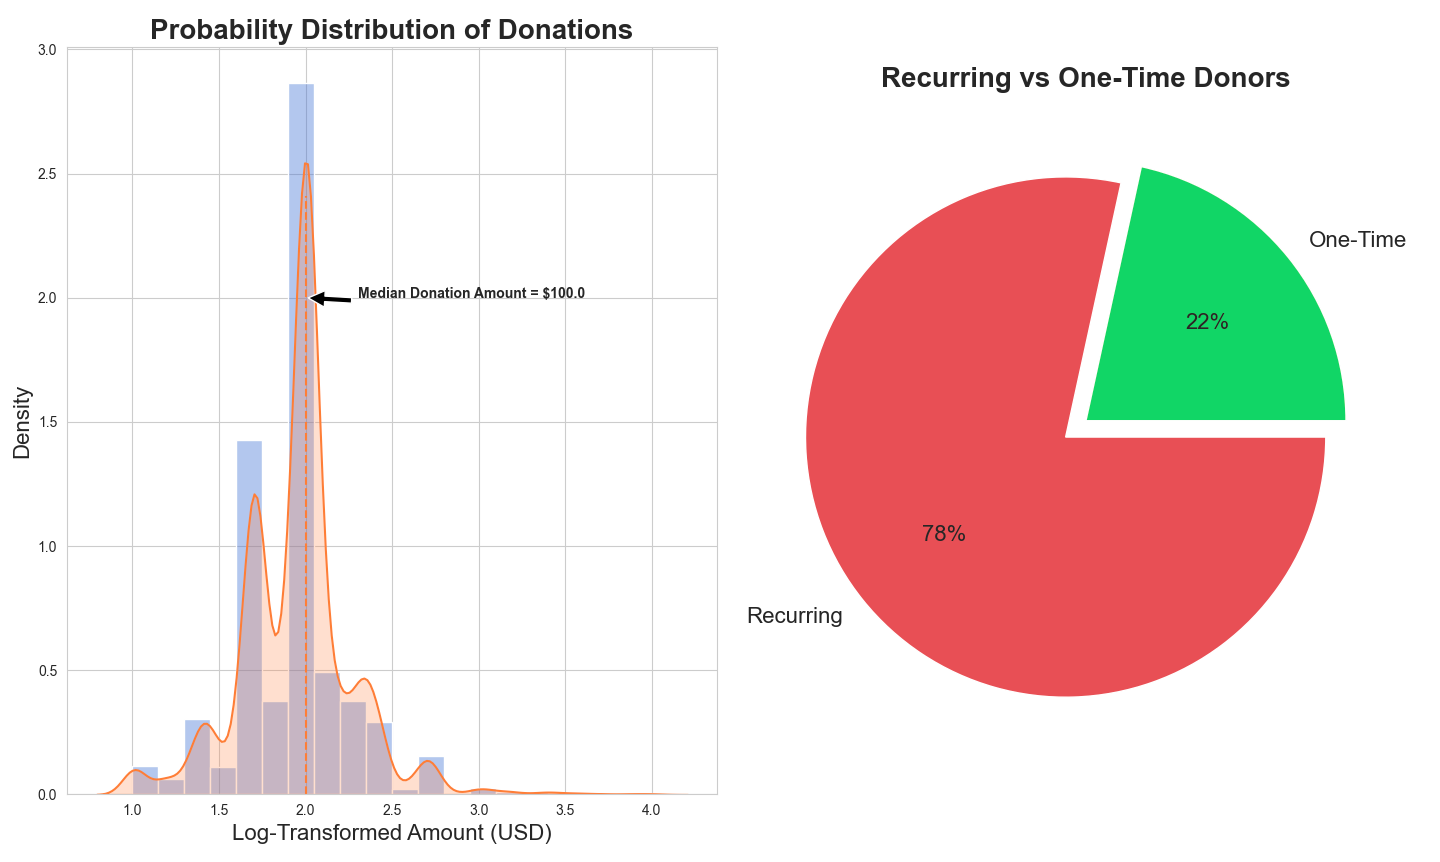

### Top One-Time Donors (By Total Giving)
>This table highlights the **top 10 one-time donors**, ranked by their total donation amount (monetary value).  
>
>To maintain donor privacy, real names have been replaced with anonymous labels (e.g., `donor_0`, `donor_1`, etc.).
>
>These donors contributed significantly despite not giving on a recurring basis which could suggest that they have a **high capacity for giving in one-time events** (e.g., end-of-the-year fundraising campaigns) and may be targeted for future engagement. 

In [32]:
# Filter one-time donors, order by monetary value 
one_time_donors = (
    donors_df.loc[~donors_df['is_recurring'], 
    ['donor_name', 'monetary', 'recency']]
    .sort_values(by = 'monetary', ascending = False)
)

# Assign aliases to donor names to protect privacy
one_time_donors['donor_name'] = one_time_donors.index.map(lambda x: f'donor_{x}')

# Show top 10 one-time donors (according to monetary)
one_time_donors.set_index('donor_name').head(10)

,monetary,recency
donor_name,,
donor_46,10000.0,429
donor_114,7500.0,1188
donor_13,3000.0,102
donor_26,2500.0,1151
donor_104,1500.0,586
donor_48,1200.0,1178
donor_85,1100.0,614
donor_112,1000.0,149
donor_106,750.0,588


### Proportion of Donors with Outlier Donations
>- We first classify **outlier donations** in the transaction dataset using the **IQR method** and a helper function (`iqr_outlier_flags`).
>- Then we calculate the **proportion of donors** who have given **at least one outlier donation**.
>-  Finally, we construct a **95% confidence interval** for this proportion using the normal approximation.

In [24]:
# Function to flag outlier donations within each donor's giving history
def iqr_outlier_flags(amount_series):

    # Compute quartiles & IQR based on donations
    q1 = amount_series.quantile(0.25)
    q3 = amount_series.quantile(0.75)
    iqr = q3 - q1 

    # Outlier detection thresholds
    lower = q1 - (iqr*1.5)
    upper = q3 + (iqr*1.5)
    
    # Return boolean mask for outlier rows
    return (amount_series < lower) | (amount_series > upper)

>- We are **95% confident** that the true proportion of donors who give at least one outlier donation lies **between 0.103 and 0.227**.
>- This means that **if we repeated this sampling process many times**, approximately **95% of the confidence intervals** we construct would **contain the true proportion** of donors with outlier donations.

In [25]:
# Create a per-transaction boolean column showing whether each donation is an outlier
transactions_df['is_outlier'] = (
    transactions_df
    .groupby('donor_name')['amount']
    .transform(iqr_outlier_flags)
)

# Count donors who have at least one outlier donation
num_outlier_donors = (
    transactions_df
    .groupby('donor_name')['is_outlier']
    .any().sum()
)

# Total number of unique donors
num_donors = transactions_df['donor_name'].nunique()

# Sample proportion: probability a donor has an outlier donation
p = num_outlier_donors / num_donors
print(f'Sample proportion of donors with outlier donations: {p:.3%}')

# Check whether or not we can use the normal approximation
if num_donors*p >= 10 and num_donors*(1-p) >= 10:
    print('The distribution of the sample proportion is approximately normal.')

    # Compute the standard error (SE)
    se = np.sqrt(p*(1-p) / num_donors)

    # Compute the z critical value
    # Compute the margin of error (MOE) 
    alpha = 0.05 # 95% confidence
    z = norm.ppf(1-(alpha / 2))
    moe = z*se 
    
    print(f'The 95% confidence interval is {p:.3f} +/- {moe:.3f}')
else:
    print('Normal approximation conditions not met — consider alternative methods.')

Sample proportion of donors with outlier donations: 16.547%
The distribution of the sample proportion is approximately normal.
The 95% confidence interval is 0.165 +/- 0.062


### Monthly Donor Identification & Summary Table
>This section focuses on determining which donors qualify as **monthly givers** and producing a **classification summary**. The workflow includes:
>
>**Computing donation intervals:**
>- Transactions are sorted by donor and date.
>- For each donor, we calculate the **days between consecutive gifts**.
>- We then take the **median of the last three intervals** as a stable estimate of their recent giving cadence.
>
>**Classifying monthly donors:**
>- A donor is labeled monthly if their median interval is **< 35 days**, and they are already marked as **recurring**.
>- This avoids misclassifying recurring donors who give irregularly.
>
>**Generating a classification summary table:**
>- **Recurring Monthly** — recurring donors who give approximately monthly
>- **Recurring Not Monthly** — recurring donors with irregular intervals
>- **One Time** — donors who have given only once or are not recurring
>- **Totals** — total number of donors evaluated

In [ ]:
donors_df = donors_df.merge(
    # Work with transactions sorted by donor and date so diff() gives correct intervals
    transactions_df
        .sort_values(by = ['donor_name', 'date'], ascending = True)
        # .assign creates a NEW column and returns a new DataFrame (doesn't modify in-place)
        # Syntax: .assign(new_col=lambda df: ... ) where the df inside lambda
        # refers to the DataFrame after the sort_values above.
        # Here we compute days between consecutive donations per donor
        .assign(days_since_prev = lambda df: df.groupby('donor_name')['date'].diff().dt.days)
        # Aggregate each donor to a single row by taking median donation gap over the last 3 donations
        .groupby('donor_name')['days_since_prev'].apply(lambda x: x.tail(3).median())
        .rename('median_recent_interval'),
    how = 'left', on = 'donor_name')

# Donor is considered "monthly" if:
# - Their median donation interval is less than 35 days
# - AND we already flagged them as recurring supporters
# - .lt() is "less than" method in pandas
donors_df['is_monthly'] = (donors_df['median_recent_interval'].lt(35) & donors_df['is_recurring'])

In [25]:
# Build a summary table of donor segmentation and counts
summary = pd.DataFrame({
    'Category': [
        'Recurring Monthly',  # Recurring donors who give approx monthly (<35 day median interval)
        'Recurring Not Monthly', # Recurring donors who donate but not on a monthly consistency
        'One Time', # Donors with no recurring history
        'Totals' # Total donor count
    ],
    'Counts': [
        #Count monthly supporters (True = 1 when summed)
        (donors_df['is_monthly']).sum(),
        
        # Recurring donors that are NOT monthly:
        # must be recurring AND not monthly
        (donors_df['is_recurring'] & ~donors_df['is_monthly']).sum(),

        # Non-recurring donors (one-timers)
        (~donors_df['is_recurring']).sum(),
        
        # Total donors, counting rows in donors_df
        (donors_df['donor_name']).count()
    ]
# Make category names the index so the table is clean and readable
}).set_index('Category')

summary # Display the final summary table

,Counts
Category,
Recurring Monthly,103
Recurring Not Monthly,6
One Time,30
Totals,139


>- Each of these donor categories exhibits **distinct giving behaviors** and will therefore be **treated separately during segmentation**.
>- **One-time donors** and **non-monthly recurring donors** will be assigned to dedicated **segments**: `one_time` and `rec_not_monthly`.
>- More detailed analysis, such as feature binning and RFM scoring, is **applied exclusively to monthly donors**, where additional **sub-segments** are created.

### Distribution of Recency, Frequency, and Monetary (RFM) Value
>In this section, we visualize the distribution of the three key RFM (**Recency, Frequency, Monetary**) features using box plots for **monthly donors**.
>
> This helps us:
>- Understand the **range** and **central tendency** of each feature.
>- Identify the presence of **outliers**.
>- Assess the **skewness** of each distribution. 

In [ ]:
# Initialize figure with 3 subplots 
fig, ax = plt.subplots(1, 3, figsize = (15, 8))

# Filter for monthly donors
monthly_donors_df = donors_df.loc[donors_df['is_monthly'], :]

# Define RFM features
rfm_features = ['recency', 'frequency', 'monetary']

# Box plots for RFM features
fig.suptitle('Distribution of RFM Value', fontsize = 20, fontweight = 'bold')
for i, feat in enumerate(rfm_features):
	sns.boxplot(
        y = monthly_donors_df[feat], showfliers = True, ax = ax[i], width = 0.7, 
        color = palette[i], flierprops = {'mfc' : 'black', 'marker': 'D'}
    )
	ax[i].set_ylabel(feat, fontsize = 16)

fig.tight_layout()
plt.savefig('rfm_features_box_updated.png')

>**RFM Distributions**
>
>- **Recency**: The median, lower quartile, and minimum are all very close together despite a wide, overall range. This suggests that most donors have given recently while few donors have not given in a long time. In particular, **the majority of monthly donors remain fully engaged**, while a smaller portion have lapsed or fully churned.
>- **Frequency**: The interquartile range shows that **the middle 50% of monthly donors** have given somewhere **between 15 and 35 donations**, while the median indicates that most donors within this group fall toward the higher end of that range.
>- **Monetary**: While the distribution is **largely symmetric**, with a **median around $2,000**, a small number of extreme outliers indicate the presence of exceptionally generous monthly donors.

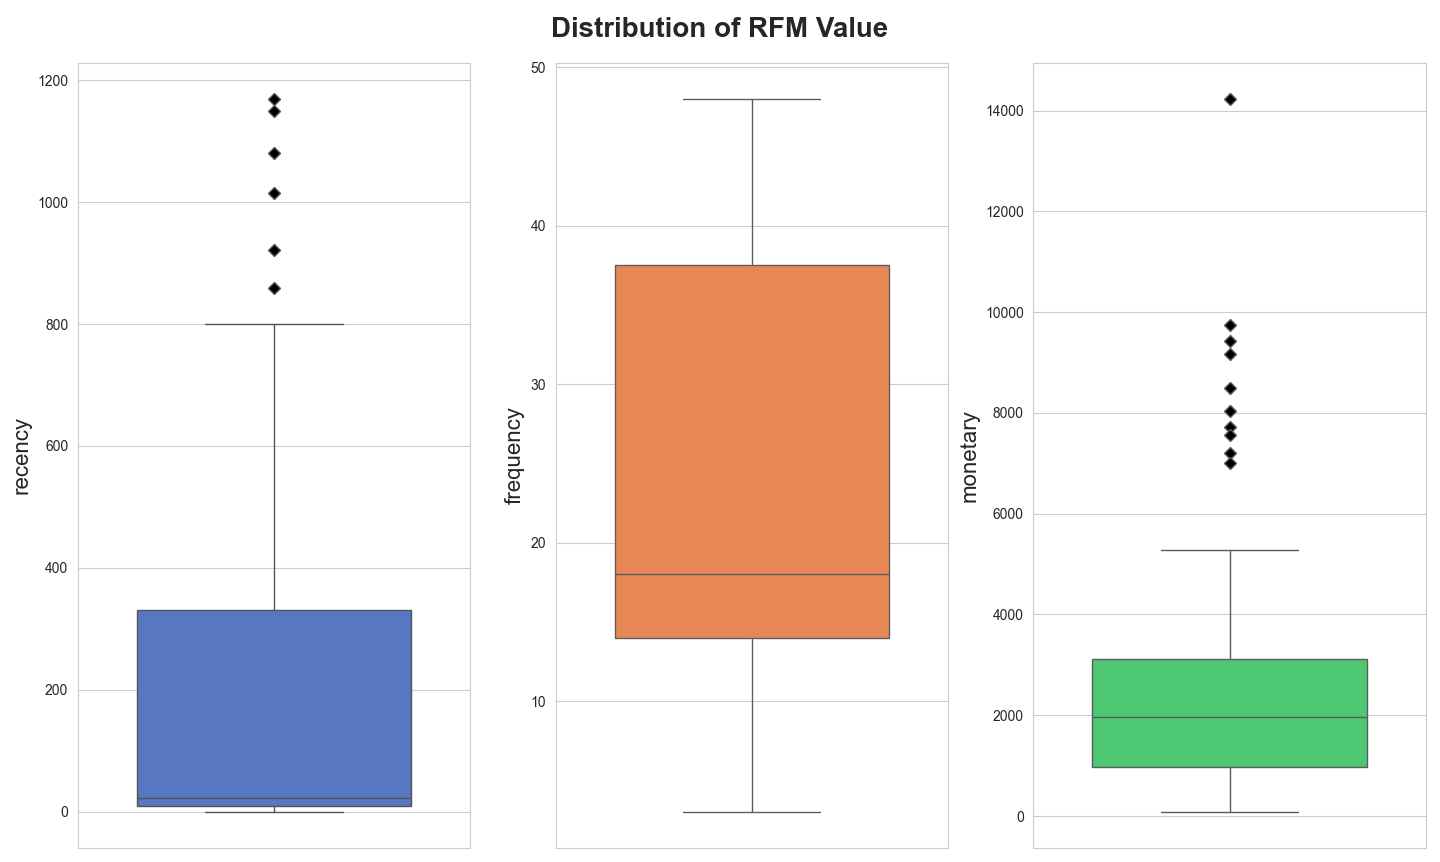

### State-by-State Analysis of Donation Totals & Donor Numbers
>To understand the geographic distribution of giving behavior, we conducted a **state-level analysis** of donor contributions which shows:
>- The **total donation amount** contributed by donors in each state.
>- The **number of individual donors** per state, offering insight into regional donor concentration. 
>
> These findings are especially useful for strategic planning. Since we travel to the U.S. once a year for in-person donor engagement and fundraising, this data helps us **prioritize which states or regions to focus our efforts on**, maximizing relational and fundraising impact.


In [ ]:
# Initialize figure with two subplots 
fig, ax = plt.subplots(1, 2, figsize = (15,8))

# ---- Compute State-Level Donation Totals ----
# Merge donor state info into the transaction dataset,
# group by state, then compute total donation amount per state
donation_totals_by_state = (
	pd.merge(
		transactions_df, 
		donors_df[['donor_name', 'state']], 
    	how = 'left', 
    	on = 'donor_name')
	.groupby('state', as_index = False)
	.agg({'amount' : 'sum'})
	.sort_values(by = 'amount', ascending = False)
	.reset_index(drop = True)
)

# ---- Compute Donor Counts by State ----
# Group donors by state and count unique donor names
donor_counts_by_state = (
	donors_df.groupby('state', as_index = False)
	.agg(**{'donor_counts': ('donor_name', 'count')})
	.sort_values(by = 'donor_counts', ascending = False)
	.reset_index(drop = True)
)

# Bar plot for total donations by state 
ax[0].bar(donation_totals_by_state['state'], donation_totals_by_state['amount'], color = palette)
ax[0].set_xticks(ticks = range(len(donation_totals_by_state)), labels = donation_totals_by_state['state'], rotation = 45)
ax[0].set_ylabel('Amount (USD)', fontsize = 16)
ax[0].set_xlabel('State', fontsize = 16)
ax[0].set_title('Total Donations By State', fontweight = 'bold', fontsize = 20)

# Bar plot for number of donors per state
ax[1].bar(donor_counts_by_state['state'], donor_counts_by_state['donor_counts'], color = palette)
ax[1].set_xticks(ticks = range(len(donor_counts_by_state)), labels = donor_counts_by_state['state'], rotation = 45)
ax[1].set_ylabel('Number of Donors', fontsize = 16)
ax[1].set_xlabel('State', fontsize = 16)
ax[1].set_title('Number of Donors Per State', fontweight = 'bold', fontsize = 20)

plt.savefig('state_by_state_bar_updated.png')

> **Total Donations By State**
> - The bar plot reveals that donors in **Arizona** contribute the **largest share of total donations**, with **Texas** following as the **second-highest**.
>
> **Number of Donors per State**
> - The bar plot indicates that **donor count is highest in Arizona**, with **Texas** having the **second-largest donor base**.
>
> Donor counts and total donations are highest in Arizona and Texas, suggesting these states may offer the strongest  opportunities for **in-person engagement and fundraising**.

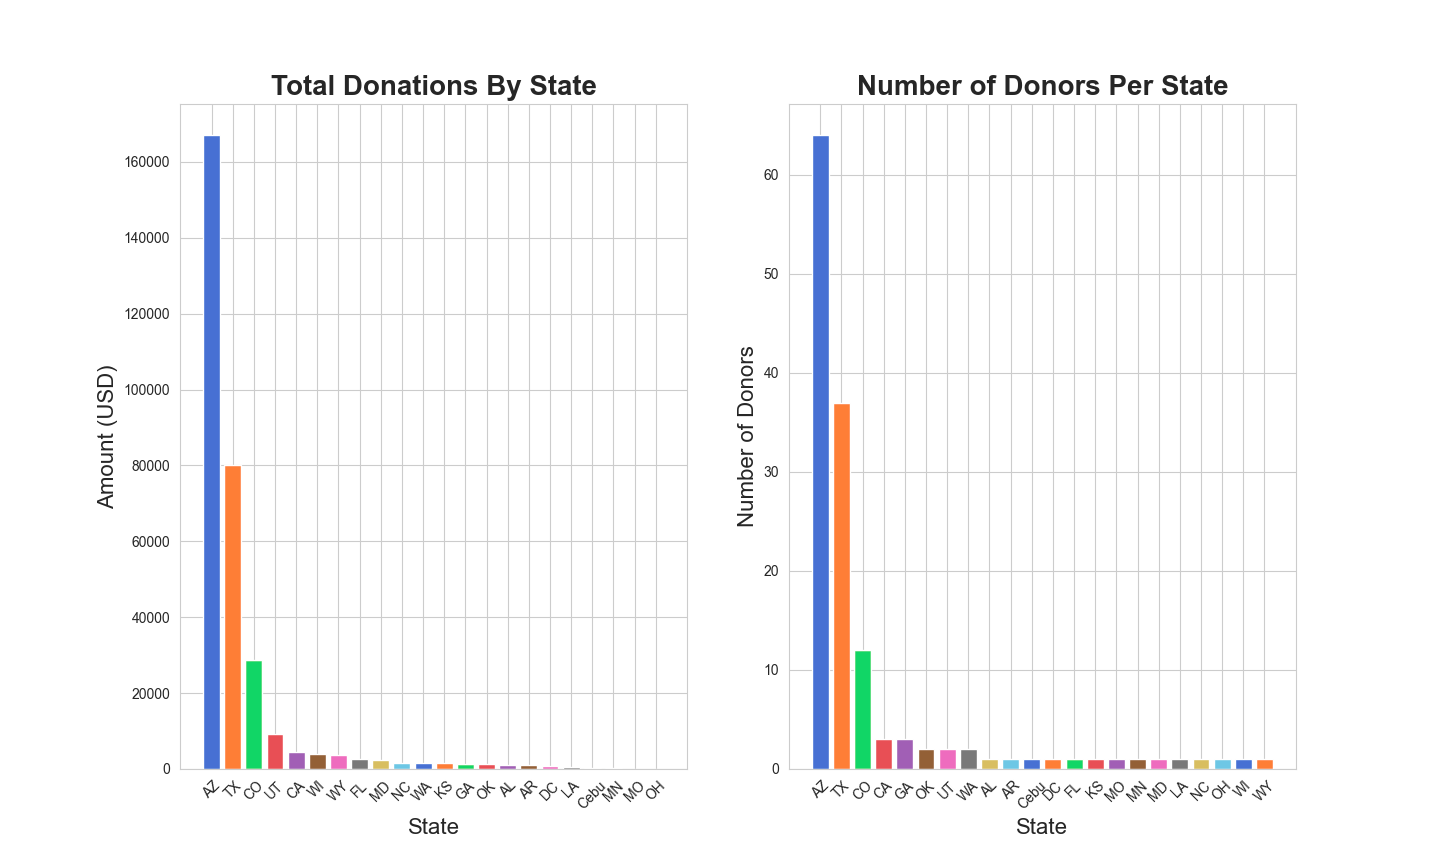

## Donor RFM Scoring & Segmentation 

### RFM Quantile-Based Scoring
> In this section, we build donor segments and compute RFM (**Recency-Frequency-Monetary**) scores for **monthly donors**.
> - **Initial Segmentation:** RFM scoring is applied only to monthly donors. **One-time donors** and **non-monthly recurring donors** are instead placed into separate categories: `one_time` and `rec_not_monthly`.
> - **Recency scoring (R-score):** Monthly donors are classified as **engaged, lapsed, or churned** (3, 2, or 1) by comparing their `recency` to **1.5x their median donation interval**.
> - **Frequency & Monetary scoring (F-score, M-score):** Monthly donors are binned into quartiles using **25th/50th/75th percentiles** to assign scores from 1-4.
> - **Final RFM score:** For monthly donors, `rfm_score = r_score + f_score + m_score`, then merged back into the main DataFrame. 

In [26]:
# ----------------------------------------------------------------
# INITIAL SEGMENT LABELING BASED ON RECURRING STATUS
# ----------------------------------------------------------------

# Start with no segment label
donors_df['segment'] = None

# One-time donors
one_time_mask = ~donors_df['is_recurring']
donors_df.loc[one_time_mask, 'segment'] = 'one_time'

# Recurring but not monthly
rec_not_monthly_mask = donors_df['is_recurring'] & ~donors_df['is_monthly']
donors_df.loc[rec_not_monthly_mask, 'segment'] = 'rec_not_monthly'

# Keep a mask and subset for monthly donors
monthly_mask = donors_df['is_monthly']
monthly_df = donors_df.loc[monthly_mask]

# ----------------------------------------------------------------
# R-SCORE (RECENCY) FOR MONTHLY DONORS
# Rule: recency relative to 1.5 * median donation interval
# ----------------------------------------------------------------

donors_df['r_score'] = None # initialize as blank

interval = donors_df['median_recent_interval']
recency = donors_df['recency']

# Classify fully engaged monthly donors (not lapsed or churned)
donors_df.loc[monthly_mask & (recency < 1.5*interval), 'r_score'] = 3

# Classify monthly donors who have lapsed in their giving
donors_df.loc[monthly_mask & (recency >= 1.5*interval) & (recency <= 120), 'r_score'] = 2

# Classify monthly donors who have churned (considered to be lost)
donors_df.loc[monthly_mask & (recency >= 120), 'r_score'] = 1

# ----------------------------------------------------------------
# BUILD QUANTILE BINS FOR FREQUENCY & MONETARY (MONTHLY DONORS)
# ----------------------------------------------------------------

def compute_bins(df, feature):
    # Compute quartile-based bins for a feature
    # Returns: [0, 25%, 50%, 75%, inf]
    q1, q2, q3 = df[feature].quantile([0.25, 0.50, 0.75])
    return [0, q1, q2, q3, np.inf]

# Compute bins for monthly donors (monthly_df)
frequency_bins = compute_bins(monthly_df, 'frequency')
monetary_bins = compute_bins(monthly_df, 'monetary')

# ----------------------------------------------------------------
# ASSIGN F-SCORE & M-SCORE USING QUARTILE BINS
# ----------------------------------------------------------------

# Initialize scores 
donors_df[['f_score', 'm_score']] = None

# Compute frequency scores
donors_df.loc[monthly_mask, 'f_score'] = pd.cut(monthly_df['frequency'], bins = frequency_bins, labels = [1, 2, 3, 4])

# Compute monetary scores
donors_df.loc[monthly_mask, 'm_score'] = pd.cut(monthly_df['monetary'], bins = monetary_bins, labels = [1, 2, 3, 4])

# ----------------------------------------------------------------
# MERGE RFM SCORES FOR MONTHLY DONORS TO MAIN DATAFRAME
# ----------------------------------------------------------------

# Reassign monthly_df with mask 
monthly_df = donors_df.loc[monthly_mask]

donors_df = donors_df.merge(
    # Create rfm_score vectorized and keep only donor_name + rfm_score
    monthly_df.assign(
        rfm_score = lambda df: df['r_score'].astype('str') + df['f_score'].astype('str') + df['m_score'].astype('str')
    )[['donor_name', 'rfm_score']],
    on = 'donor_name', how = 'left'   
)

### Assigning Donor Segments Using RFM Scores
>We assign donor segments **only for monthly donors** by applying **regular expression rules** to their **RFM score** (Recency, Frequency, Monetary), and specific patterns are mapped to meaningful behavioral segments.
>
>**Monthly Donor Segments:**
>- `champions`: Fully engaged monthly donors with the highest frequency and monetary value.
>- `loyal_donors`: Fully engaged monthly donors who give frequently but with moderate monetary amounts.
>- `big_spenders`: Fully engaged monthly donors who give large amounts but have not yet reached high donation frequency.
>- `lapsed`: Monthly donors whose giving has slowed relative to their historical cadence, but who have not fully churned.
>- `churned`: Monthly donors who have not given for an extended period and are considered disengaged.
>
>**Additional Handling:**
>- Monthly donors whose RFM scores do not match any of the above patterns are labeled `other`.
>- **Non-monthly recurring donors** and **one-time donors** retain their previously assigned segments (`rec_not_monthly`, `one_time`) and are excluded from RFM-based segmentation.

In [27]:
# Define a segmentation map using regular expressions and RFM scores
seg_map = {
    r'2[1-4][1-4]': 'lapsed', # Monthly donors who have lapsed in their giving but not fully churned -- 1.5x median_recent_interval < recency < 120 
    r'1[1-4][1-4]': 'churned', # Monthly donors who have churned (considered to be lost or fully unengaged) -- 120 < recency 
    r'3[1-2]4': 'big_spenders', # Monthly donors who are engaged & give large amounts but have not yet given frequently -- potential champions
    r'3[3-4][1-3]': 'loyal_donors', # Monthly donors who are engaged, have given the most frequently, but not as generously as champions
    r'[3]44': 'champions' # Monthly donors who are engaged, have given the most frequently and most monetary -- most valuable donors
}

# Reassign monthly_df with mask 
monthly_df = donors_df.loc[monthly_mask]

# Segment donors according to seg_map, adding easily identifiable lables (e.g., 'lapsed')
donors_df.loc[monthly_mask, 'segment'] = monthly_df['rfm_score'].replace(seg_map, regex = True)

# All donors who do not fall into the aforementioned categories will be labeled as 'other'
donors_df.loc[~donors_df['segment'].isin(list(seg_map.values()) + ['rec_not_monthly', 'one_time']), 'segment'] = 'other'

# Quick summary of RFM scores and segments
donors_df[['segment', 'r_score', 'f_score', 'm_score', 'rfm_score']].describe()

,segment,r_score,f_score,m_score,rfm_score
count,139,103,103,103,103
unique,8,3,4,4,27
top,churned,3,1,2,344
freq,32,68,41,26,17


> This segmentation strategy is adapted from the article:
> [Customer Segmentation with RFM Analysis using Python](https://medium.com/@gurkanc/customer-segmentation-with-rfm-analysis-using-python-8ba043252d33)

## Donor Segmentation Overview & Insights

### Donor Segment Behavior Analysis
> To better understand donor behavior after RFM scoring, we used bar plots to summarize:
> - The **number of donors** in each segment.
> - The corresponding **total donation value** of each segment.

In [ ]:
# Initialize figure with two subplots
fig, ax = plt.subplots(1, 2, figsize = (15, 8)) 

# Alphabetically order the segments for consistency in visuals 
ordered_segments = sorted(donors_df['segment'].unique())

# Count plot for donor segments 
sns.countplot(data = donors_df, x = 'segment', palette = palette, ax = ax[0], order = ordered_segments)
ax[0].set_xticklabels(labels = ordered_segments, rotation = 45, ha = 'center')
ax[0].set_xlabel('Donor Segment', fontsize = 16)
ax[0].set_ylabel('Count', fontsize = 16)
ax[0].set_title('Number of Donors Per Segment', fontsize = 20, fontweight = 'bold')

# Compute the total amount in donations per donor segment 
segment_monetary = donors_df.groupby('segment', as_index = False).agg({'monetary' : 'sum'})

# Bar plot for total donations per segment
sns.barplot(data = segment_monetary, x = 'segment', y = 'monetary', palette = palette, ax = ax[1], order = ordered_segments)
ax[1].set_xticklabels(labels = ordered_segments, rotation = 45, ha = 'center')
ax[1].set_xlabel('Donor Segment', fontsize = 16)
ax[1].set_ylabel('Amount (USD)', fontsize = 16)
ax[1].set_title('Total Donations Per Segment', fontsize = 20, fontweight = 'bold')

fig.tight_layout()
plt.savefig('donor_segmentation.png')

> **Number of Donors per Segment**:
>- This count plot shows how many donors fall into each segment.
>- Most donors belong to the `churned` category, followed by `other`, suggesting that a large portion of the donor base is **either no longer engaged or does not exhibit clear behavioral patterns captured by the current segmentation**.
>  
> **Total Donations per Segment**:
>- This bar plot highlights the **total monetary contribution** of each segment.
>- The majority of donations come from `champions`, followed by `churned`, suggesting that while the `one-time` and `other` groups are large, `champions` remain **the most financially impactful**.

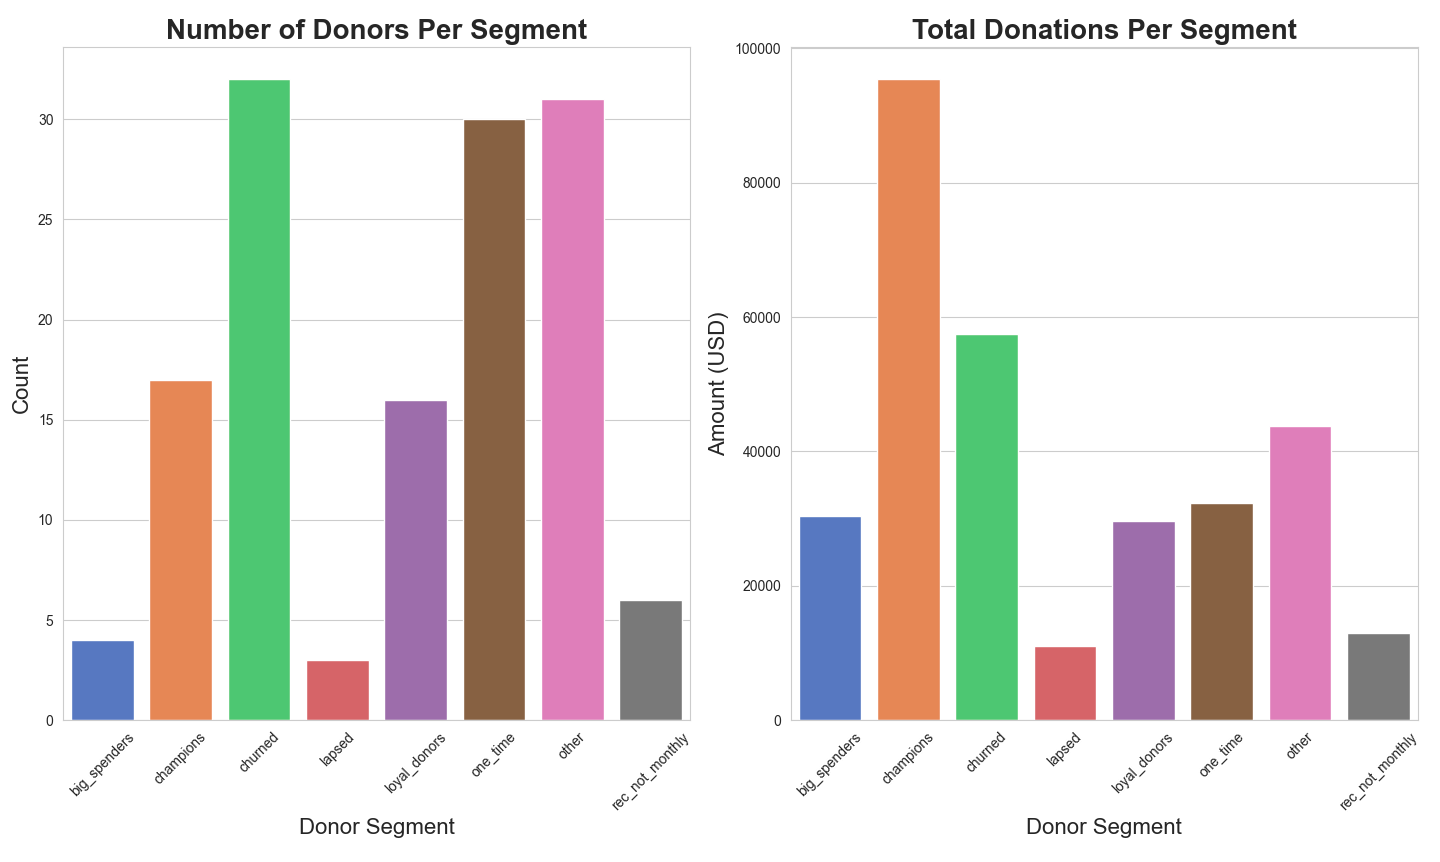

### Donor Segmentation by State: Arizona, Texas, & Colorado
>To explore how **donor behavior varies geographically**, we generated a heatmap showing the **number of donors in each segment across three key states** (containing the highest volume of donors across all states): Arizona (AZ), Texas (TX), and Colorado (CO).
>
>Each cell shows the donor count for a specific segment and state combination.

In [ ]:
# Filter for states of interest
target_states_df = donors_df[donors_df['state'].isin(['AZ', 'TX', 'CO'])]

# Group by state & donor segment, and compute the number of donors
segment_counts_by_state = (
    target_states_df
        .groupby(['state', 'segment'])
        .agg(**{'donor_counts': ('donor_name', 'count')})
)

# Pivot donor_counts for heatmap format
segment_counts_pivot = segment_counts_by_state.unstack(fill_value = 0)

# Determine x-axis labels 
segments = sorted(donors_df['segment'].unique())

# Initialize figure 
fig = plt.figure(figsize = (15, 8))

# Heat map for donor count by State & segment 
sns.heatmap(
    data = segment_counts_pivot, cmap = 'vlag', 
    annot = True, linecolor = 'black', xticklabels = segments, 
    linewidths = 0.5, cbar_kws = {'label': 'Donor Count'}
)
plt.title('Donor Segment Distribution Across States', fontsize = 20, fontweight = 'bold')
plt.xlabel('Donor Segment', fontsize = 16)
plt.ylabel('State', fontsize = 16)

plt.savefig('segment_heatmap_updated.png')

> This visualization illustrates the geographic distribution of donor segments, highlighting regions with a strong presence of high-value donors (champions, loyal_donors) as well as areas where re-engagement efforts may be needed (lapsed, churned).
> - **Arizona** contains the highest number of donors across several segments, including `champions`, `loyal_donors`, `one_time`, and `churned`, indicating **a broad mix of both highly engaged and fully disengaged donors**.
> - **Colorado** shows a relatively balanced distribution across segments, indicating a **symmetric but less concentrated donor base**.
> - **Texas** is dominated by the `other` segment, indicating the need for **a more robust segmentation or additional analysis** to better understand donor behavior in that state.
>
> Overall, Arizona stands out as both the largest donor market and the state with the greatest concentration of high-value donors, alongside a substantial group of donors who may benefit from targeted re-engagement efforts. For in-person fundraising initiatives in the U.S., this suggests an opportunity to both celebrate and retain `champions` while strategically reactivating `churned` donors.

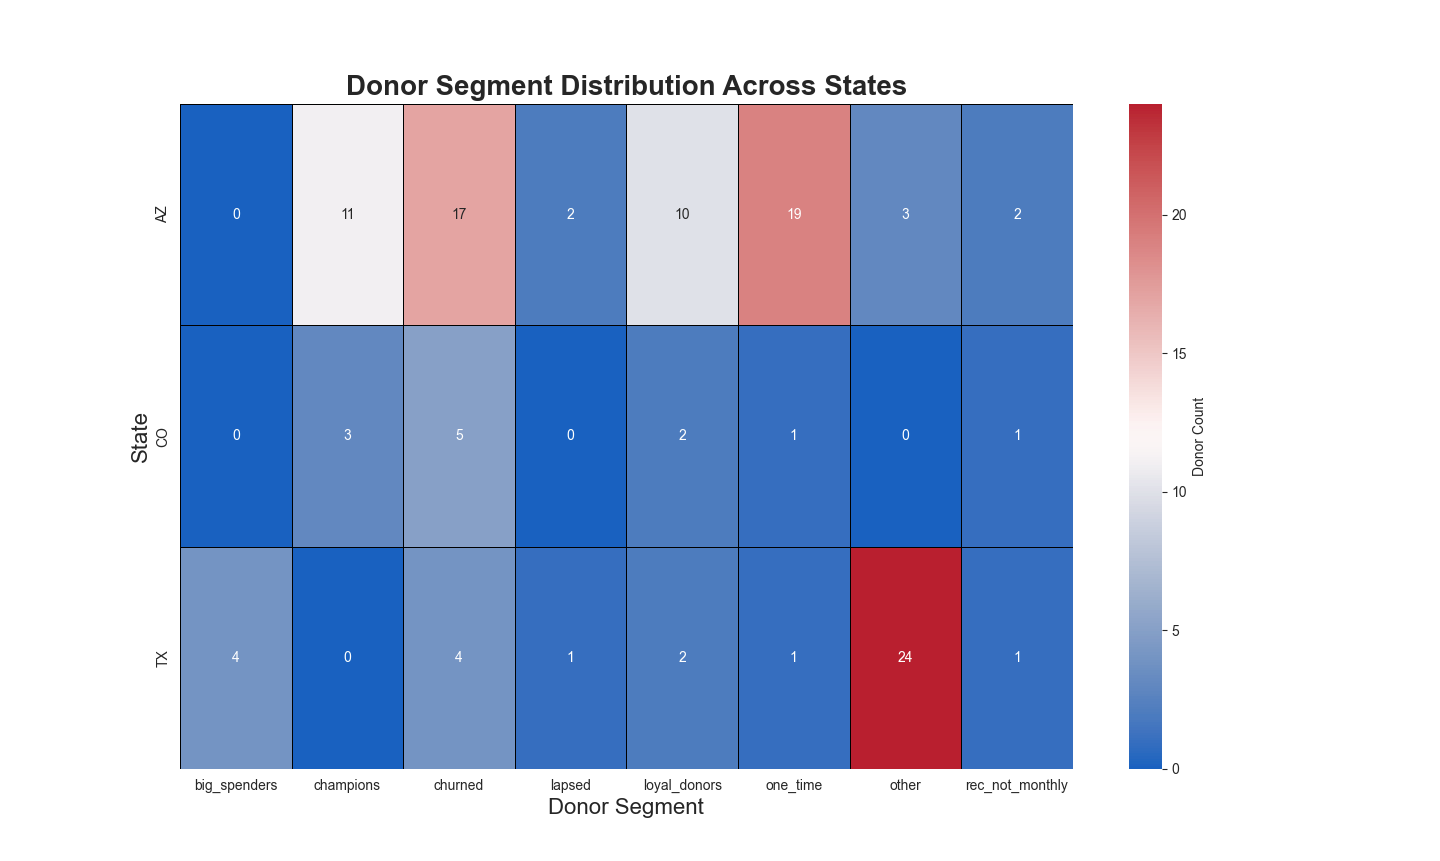

### Median Donation Amount Distributions by Segment
>In this section, we visualize and compare the distribution of donors’ **median gift amounts** across all **donor segments**.
Because donation amounts are typically **right-skewed**, the x-axis is plotted on a **logarithmic scale**, which makes differences between segments easier to interpret.
>
>This KDE plot helps highlight:
>- Which segments tend to give higher amounts
>- Overlap between donor groups
>- Whether certain segments have distinct giving patterns
>
> These distributions should be interpreted as **indicative rather than definitive**, as the segment-level **sample sizes are relatively small** (the largest segment has fewer than 35 donors).

In [ ]:
# Initialize figure 
fig = plt.figure(figsize = (15, 8))

# Plot KDE of median donation amounts by donor segment
# use log-scale to handle skewed donation amounts
sns.kdeplot(
	data = donors_df, x = 'med_amount', hue = 'segment', 
	fill = True, palette = palette, log_scale = True 
)
plt.title('Median Donation Distributions by Segment', fontsize = 20, fontweight = 'bold')
plt.xlabel('Median Donation Amount (Log Scale)', fontsize = 16)
plt.ylabel('Density', fontsize = 16)

plt.savefig('segment_median_amounts_udpated.png')

>**Median Donation Distributions by Segment:**
>- The `champions`, `lapsed`, `churned`, and `other` segments show substantial **distribution overlap**, with very **similar central tendencies**.
>- The `churned` and `other` segments exhibit nearly **identical standard deviations**, indicating that donors in these groups display **similar giving patterns**.
>- Although the **central tendencies are comparable**, the `champions` and `lapsed` segments have noticeably **smaller standard deviations** than the `churned` and `other` groups. This may be due to **smaller sample sizes**, which naturally produce less variability.
>- The `big_spenders` segment has a clearly **right-shifted distribution**, confirming the expectation that these donors give **larger amounts** relative to other groups.
>- The `one_time` donor distribution shows a **broad range of giving amounts**, with noticeable density peaks around **100 and 1,000 dollars**.

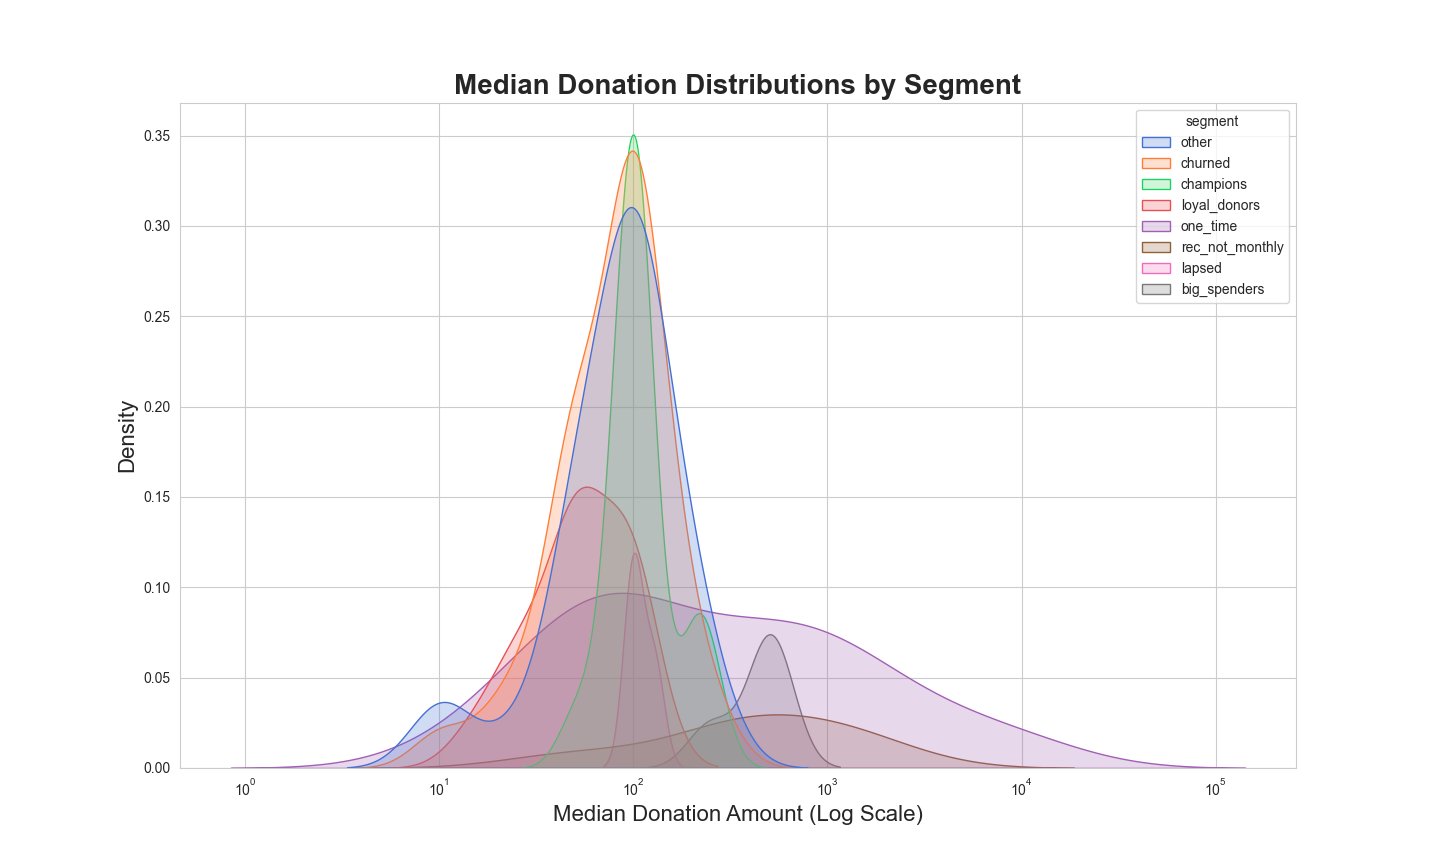

## Export Final Donors Table
> 1. **Export Processed Dataset**
> 
> Save the cleaned and fully processed `donors_df` DataFrame to a CSV file without including the index.
> 
> 2. **Anonymize Donor Names**
> 
> Replace the `donor_name` column with anonymized labels (e.g., `donor_0`, `donor_1`, …) to protect donor privacy.
> 
> 3. **Export Anonymized Dataset**
> 
> Save the anonymized version of `donors_df` to a CSV file, again excluding the index.
> 
> 4. **Preview Final Table**
> 
>Display the first ten rows of the anonymized DataFrame.

In [28]:
# Export final DataFrames before anonymizing 
donors_df.to_csv('donors_updated_final.csv', index = False)
transactions_df.to_csv('trans_updated_final.csv', index = False)

# Anonymize donor names
donors_df.loc[:, 'donor_name'] = donors_df.index.map(lambda x: f'donor_{x}')

# Remove City locations for further anonymization 
donors_df.drop(columns = 'city', inplace = True)

# Export final donors_df DataFrame to csv file 
donors_df.to_csv('donors_updated_anonymized.csv', index = False)

# View final table
donors_df.set_index('donor_name').head(10)

,state,country,monetary,frequency,donation_start_date,last_donation_date,mean_amount,med_amount,max_amount,min_amount,recency,is_recurring,median_recent_interval,is_monthly,segment,r_score,f_score,m_score,rfm_score
donor_name,,,,,,,,,,,,,,,,,,,
donor_0,TX,US,1400.0,14,2024-10-12 14:21:52,2025-11-12 19:12:12,100.000000,100.0,100.0,100.0,28,True,30.0,True,other,3,1,2,312
donor_1,AZ,US,3106.0,30,2022-03-18 23:40:00,2025-01-16 13:12:46,103.533333,100.0,206.0,100.0,329,True,30.0,True,churned,1,3,3,133
donor_2,AZ,US,3900.0,39,2022-09-15 20:03:44,2025-11-15 19:21:24,100.000000,100.0,100.0,100.0,25,True,30.0,True,champions,3,4,4,344
donor_3,TX,US,2878.0,26,2022-05-14 04:48:00,2024-10-01 15:22:45,110.692308,103.0,206.0,103.0,435,True,30.0,True,churned,1,3,3,133
donor_4,AZ,US,865.2,21,2022-10-16 17:49:36,2024-06-16 15:01:18,41.200000,41.2,41.2,41.2,542,True,30.0,True,churned,1,3,1,131
donor_5,AZ,US,370.8,18,2022-10-06 17:46:55,2024-03-06 17:45:58,20.600000,20.6,20.6,20.6,644,True,30.0,True,churned,1,2,1,121
donor_6,AZ,US,4500.0,41,2022-03-22 19:18:00,2025-11-24 19:14:27,109.756098,100.0,500.0,100.0,16,True,30.0,True,champions,3,4,4,344
donor_7,AZ,US,2000.0,20,2024-05-01 21:00:11,2025-12-01 19:25:46,100.000000,100.0,100.0,100.0,9,True,29.0,True,loyal_donors,3,3,3,333
donor_8,AZ,US,50.0,1,2022-09-15 03:15:17,2022-09-15 03:15:17,50.000000,50.0,50.0,50.0,1183,False,NaN,False,one_time,None,None,None,NaN


## Key Insights & Recommendations
> **1. One-Time Donors Present a Strategic Opportunity**
>
> Approximately **22% of donors have given only once**, representing around **30 individuals**. These one-time donors (mostly concentrated in Arizona) are a **prime target for re-engagement efforts**. With thoughtful outreach and communication, they may be converted into repeat or even recurring donors.
>
>**2. Proportion of Donors with Outlier Donations**
>   
> We are **95% confident** that the **true proportion** of donors who give **at least one outlier donation** lies **between 0.103 and 0.227**.
>
>**3. Recency Data Indicates Strong Recent Engagement**
>
>The `recency` box plot reveals a **highly right-skewed distribution**, where the median, lower quartile, and minimum values are closely aligned. This suggests that **most donors have contributed recently**, with relatively few long-lapsed donors. This pattern indicates healthy, ongoing engagement across the donor base.
>
>**4. Geographic Trends Highlight Key Donor Hubs**
>   
>Donors from **Arizona** and **Texas** not only make up the **largest share of the U.S. donor base** but also generate the **highest donation volumes**. These states hold significant strategic value for future campaigns and **localized engagement** efforts. When conducting in-person fundraising or donor relations during visits to the U.S., prioritizing Arizona and Texas may yield the greatest return.
>
>**5. Champions Drive the Majority of Donations**
>   
>Unsurprisingly, `champions` (high-value, high-frequency, and fully engaged donors) account for the **majority of donation volume**. This underscores the importance of **recognizing and retaining** these key contributors. We recommend implementing targeted **appreciation campaigns**, such as **personalized thank-you messages**, to reinforce their engagement and encourage continued giving.
> 
> **6. 31% of Monthly Donors Have Churned**
> 
>Of the 103 monthly donors, **32 are classified as fully unengaged** (`churned`) based on their `recency`. This implies an approximate **69% retention rate** and highlights an opportunity for deeper analysis into behavioral patterns that precede donor churn.
> 
>**7. Donor Segment Distribution by State**
>- **Arizona** has the highest number of `champions`, highlighting a strong core of highly engaged donors. However, it also has the highest number of `one_time` and `churned` donors, indicating opportunities to **re-engage less active supporters** alongside **celebrating top donors**.
>- **Texas** has the highest concentration of `other` donors, suggesting that existing segments may not fully capture the diversity of giving behaviors. This highlights an opportunity for **enhanced segmentation or targeted exploratory analysis**.

## Limitations & Future Directions
>
>**1. Limited Donor Attributes**
>
>This analysis did not incorporate donor demographics or campaign-specific information, both of which are critical for understanding giving behavior at a deeper level. Incorporating data such as age, location, communication engagement (e.g., email opens, social media interactions), and response to specific fundraising campaigns would allow for more targeted segmentation and actionable insights. We recommend collecting this data in future analyses (manually, if necessary) to enable a more holistic understanding of our donor base.
>
>**2. Incomplete Donor Coverage**
>
>The dataset used represents only a subset of the broader Tokyo Student Mobilization donor base. As such, the findings, especially geographic and behavioral trends, may not generalize to the full population. Additionally, this may introduce bias into inferential statistics (e.g., confidence intervals) by violating the assumption that observations are independent and identically distributed (i.i.d.). Expanding the scope to include more comprehensive donor data will enhance representativeness and allow for more confident conclusions.
>
>**3. Fragmented Donation Histories**
>
>Due to organizational structure, which includes multiple subdivisions (individual, state, and national levels), this analysis reflects donations to only one specific subdivision. Donors who contribute to multiple projects or individuals across the organization may have fragmented records that are not captured here. Because centralized access to cumulative donor data is limited, achieving a full view of each donor’s giving history remains a challenge.
>
>**4. Binning Limitations in RFM Scoring**
>
>RFM segmentation in this analysis relied on quantile-based binning to assign scores across frequency and monetary value. However, this method may lead to misclassification, as donors with very similar scores might fall into different segments solely due to quantile boundaries. Additionally, quantile binning does not account for natural structure or clustering in the data. Future work should explore more robust segmentation approaches, such as k-means clustering, DBSCAN, or other unsupervised machine learning techniques, to improve classification accuracy.



## Conclusion
>This analysis aimed to segment donors based on their giving behavior in order to guide strategic engagement, retention initiatives, and geographically informed fundraising efforts. Key findings revealed that a small subset of high-value donors—classified as "champions"—accounted for the majority of total donations. In contrast, approximately 22% of donors have given only once, highlighting a significant opportunity for re-engagement and cultivation.
>
>Geographic analysis showed a clear concentration of donors in Arizona and Texas, both in terms of volume and contribution amount. These findings suggest that future in-person fundraising efforts, particularly during annual visits to the U.S., should prioritize these regions for maximum impact.
>
>To strengthen donor retention, targeted outreach should be focused on donors identified as "lasped" or "churned", using personalized communication efforts to re-establish engagement. Looking ahead, future analyses should integrate donor demographics, campaign-specific data, and engagement metrics to enable more comprehensive segmentation. Additionally, implementing more advanced clustering techniques, such as k-means or other unsupervised machine learning models, could yield more refined donor groupings and actionable insights.